In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import numpy as np

#### setting up 

In [2]:
# 1. SETUP PATHS
# This follows the 'processed' alias to your Local_Data
base_dir = os.path.abspath('../data/processed')
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# 2. CONFIGURATION
IMG_SIZE = 150  # We force all images to this size: small enough but still detailed for our case
BATCH_SIZE = 32 # We feed 32 images at a time to the model: it's enough images to get a good "average" of what the data looks like.

print(f"Training on data from: {train_dir}")
print(f"Validating on data from: {val_dir}")

Training on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/train
Validating on data from: /Users/paolominini/Projects/rps-cnn-classifier/data/processed/val


### generators definition for proper training and evaluation

In [3]:
# 3. DEFINE GENERATORS

# Train: Augmentation enabled (Hard mode for learning)
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize pixel values (0-1)
    rotation_range=40,      # Twist up to 40 degrees
    width_shift_range=0.2,  # Move Left/Right 20%
    height_shift_range=0.2, # Move Up/Down 20%
    shear_range=0.2,        # Slant/Perspective distortion
    zoom_range=0.2,         # Zoom in/out 20%
    horizontal_flip=True,   # Mirror flip
    fill_mode='nearest'     # Fill gaps with neighbor color
)

# Validation;
val_datagen = ImageDataGenerator(rescale=1./255)

# 4. LOAD DATA
# flow_from_directory looks at the folder directory and extracts images (32) automatically assigning them the proper label given the 
# fact they belong to a certain subfolder (rock, paper or scissors)

print("Loading Training Data...")
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

print("Loading Validation Data...")
validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Loading Training Data...
Found 1531 images belonging to 3 classes.
Loading Validation Data...
Found 326 images belonging to 3 classes.


## Model specification

In [4]:
# 5. BUILD THE MODEL
model = models.Sequential([
    # Block 1: The Outline Detector (32 Filters)
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    # Block 2: The Shape Detector (64 Filters)
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Block 3: The Feature Detector (128 Filters)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    
    # Block 4: The Complex Pattern Detector (128 Filters)
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten: Convert the 2D maps into a 1D list of numbers
    layers.Flatten(),
    
    # Dense: The Reasoning Layer
    layers.Dense(512, activation='relu'),
    
    # Output: The Answer (3 classes: Rock, Paper, Scissors)
    layers.Dense(3, activation='softmax') 
])

# Print a summary to check the architecture
model.summary()

/Users/paolominini/Projects/rps-cnn-classifier/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,454,147 (13.18 MB)

 Trainable params: 3,454,147 (13.18 MB)

 Non-trainable params: 0 (0.00 B)

This is a standard 4-Layer Convolutional Network.
- The "Funnel" Design (32 $\rightarrow$ 64 $\rightarrow$ 128 $\rightarrow$ 128):
    -   Layer 1 (32 Filters): This layer is shallow. It only looks for simple "edges" and "colors" (e.g., the line where a finger meets the background). We use fewer filters (32) because there are only so many ways to draw a line.
    - Layers 3 & 4 (128 Filters): Deeper layers combine those lines into complex shapes (fingers, knuckles, fists). We need more filters (128) here because the combinations are much more complex.
- MaxPooling2D(2, 2): After every learning layer, we cut the image size in half (150 $\rightarrow$ 75 $\rightarrow$ 37...).Reason: This forces the AI to summarize. It stops caring about exactly which pixel a finger is on and starts caring that there is a finger in that general area. It also massively reduces the math required, preventing your computer from "exploding."
- Dense(512): This is the "Classifier." After the visual features are extracted, these 512 neurons act like a committee that votes on what those features mean.
- Dense(3, activation='softmax'): This is the final output. It must be 3 because we have 3 classes. Softmax turns the raw math scores into probabilities (e.g., "90% Rock, 5% Paper, 5% Scissors").

In [6]:
# EarlyStopping: Stop if the model stops improving for 3 epochs (prevents wasting time)
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# ReduceLROnPlateau: If the model gets stuck, lower the learning rate to help it find the "sweet spot"
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   # Multiply LR by 0.2 (reduce it)
    patience=3,   # Wait 3 epochs before reducing
    min_lr=1e-6,
    verbose=1
)

In [7]:
# 6. COMPILE
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print("Model compiled and ready for training.")

Model compiled and ready for training.


In [8]:
# 7. TRAIN
print("Starting training...")

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("Training Complete!")

Starting training...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 277ms/step - accuracy: 0.3958 - loss: 1.0950 - val_accuracy: 0.6043 - val_loss: 1.0378 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 262ms/step - accuracy: 0.5800 - loss: 0.8926 - val_accuracy: 0.9233 - val_loss: 0.4113 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - accuracy: 0.7342 - loss: 0.6242 - val_accuracy: 0.9018 - val_loss: 0.3200 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 267ms/step - accuracy: 0.7766 - loss: 0.5314 - val_accuracy: 0.9294 - val_loss: 0.2382 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 279ms/step - accuracy: 0.8054 - loss: 0.4953 - val_accuracy: 0.9294 - val_loss: 0.2406 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 286ms/step - accuracy: 0.8321 - loss: 0.3930 - val_accuracy: 0.9141 - val_loss: 0.2492 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 294ms/step - accura

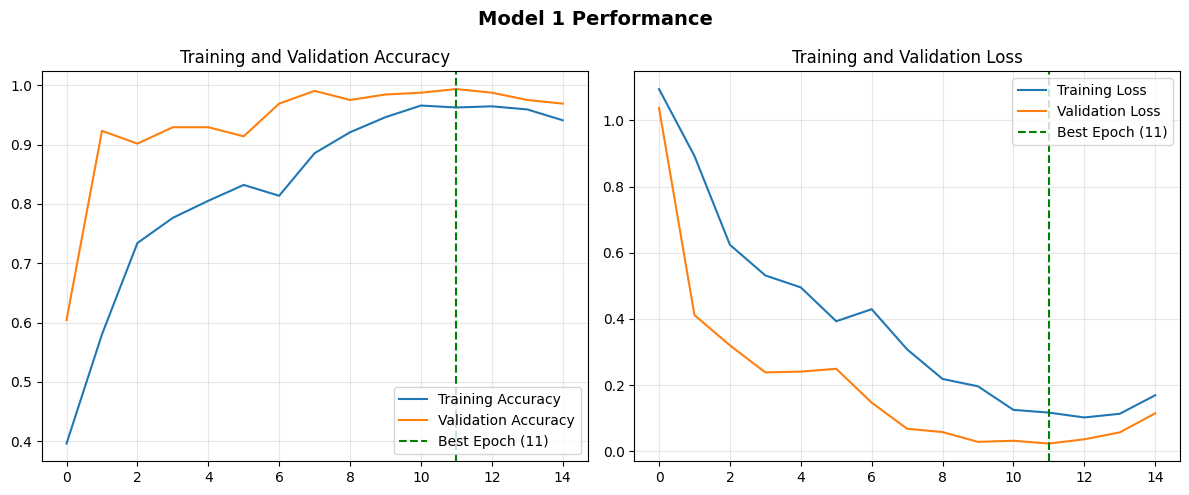

Best model was restored from Epoch 11 (Lowest Val Loss: 0.0231)


In [15]:
# 6. PLOT RESULTS OF TRAINING AND VALIDATION ACCURACY
import matplotlib.pyplot as plt

# extract data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# find best epoch for better representation
best_epoch = val_loss.index(min(val_loss))

# actual plot
plt.figure(figsize=(12, 5))

# - accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')

plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True, alpha=0.3) # Added grid for readability

# - loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
# Add vertical line at best epoch
plt.axvline(x=best_epoch, color='green', linestyle='--', label=f'Best Epoch ({best_epoch})')

plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True, alpha=0.3)

plt.suptitle('Model 1 Performance', fontweight='bold', fontsize=14)
plt.tight_layout()

# Save and Show
save_path = os.path.abspath('../reports/figures/training_history_1.png')
# plt.savefig(save_path) # Uncomment to save
plt.show()

print(f"Best model was restored from Epoch {best_epoch} (Lowest Val Loss: {min(val_loss):.4f})")

Left (Accuracy): The model achieves high accuracy (~98%) on the validation set, consistently outperforming the training set due to the heavy data augmentation applied during training.

Right (Loss): We observe that after the green line, the Validation Loss begins to plateau or slightly rise, indicating the onset of overfitting. The Early Stopping mechanism successfully detected this trend and halted training 3 epochs later, restoring the weights from the optimal point to ensure maximum generalization.

Found 326 images belonging to 3 classes.
Predicting on Validation Set...
326/326 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Total Errors: 2 out of 326 images


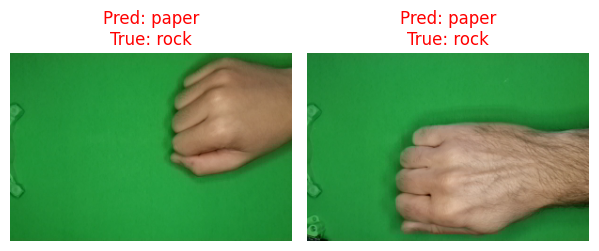

In [18]:
# 1. CREATE "AUDIT" GENERATOR (No Shuffle)
# We need this to match filenames to predictions 1-to-1
audit_datagen = ImageDataGenerator(rescale=1./255)
audit_generator = audit_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,        # Process 1 image at a time
    class_mode='categorical',
    shuffle=False        # <--- CRITICAL: Keep order fixed!
)

# get predictions
print("Predicting on Validation Set...")
predictions = model.predict(audit_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1) # e.g., [0, 1, 2, 0...]
true_classes = audit_generator.classes             # e.g., [0, 1, 2, 0...]
class_labels = list(audit_generator.class_indices.keys()) # ['paper', 'rock', 'scissors']

# find errors
# Get the indices where Prediction does NOT match Truth
errors = np.where(predicted_classes != true_classes)[0]
print(f"Total Errors: {len(errors)} out of {len(true_classes)} images")

# 4. PLOT THE MISTAKES
if len(errors) > 0:
    plt.figure(figsize=(15, 10))
    
    # We will show up to 10 errors (or fewer if there are less)
    num_to_show = min(10, len(errors))
    
    for i in range(num_to_show):
        error_index = errors[i]
        
        # Get the actual image file path
        image_path = audit_generator.filepaths[error_index]
        
        # Load and plot
        img = plt.imread(image_path)
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        
        # Title: "Pred: Rock / True: Paper"
        pred_label = class_labels[predicted_classes[error_index]]
        true_label = class_labels[true_classes[error_index]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout()
    plt.savefig(os.path.abspath('../reports/figures/mistakes_1.png'))
    plt.show()
else:
    print("Incredible! The model made ZERO mistakes on the validation set.")